In [1]:

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [3]:
df = pd.read_csv('hotel_bookings.csv',sep=',')
df = pd.DataFrame(df)

## Missing values 

In [4]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

Features agent and company have a high amount of null values, therefore both features were eliminated.

In [5]:
df = df.drop('company', axis=1)
df = df.drop('agent', axis=1)


Related to the 488 null values for country, those rows were eliminated.

In [6]:
print('country:', (df['country'].isnull().sum()/df.shape[0]))


country: 0.004087444509590418


In [7]:
df = df[df['country'].notnull()]


KeyboardInterrupt: 

Columns Adults, children and babies were unified in one column: families. Understanding that the behavior of passagers with children could be different that the behavoir of adults that can be travelling for business.

In [ ]:
df.loc[:, 'families'] = 0  # Initialize all values to 0
df.loc[(df['children'] != 0) | (df['babies'] != 0), 'families'] = 1

In [ ]:
df = df.drop('children', axis =1 )
df = df.drop('babies', axis =1 )

## Transform features to numeric.

In [ ]:
df['hotel'] = np.where(df['hotel'] == 'Resort Hotel', 1, 2)


In [ ]:
month_mapping = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

df['arrival_date_month'] = df['arrival_date_month'].map(month_mapping).fillna(0).astype(int)


In [ ]:
df['customer_type'], _ = pd.factorize(df['customer_type'])
df['market_segment'], _ = pd.factorize(df['market_segment'])
df['distribution_channel'], _ = pd.factorize(df['distribution_channel'])
df['reservation_status'], _ = pd.factorize(df['reservation_status'])



In [ ]:
df['deposit_type'], _ = pd.factorize(df['deposit_type'])

In [ ]:
df['meal'], _ = pd.factorize(df['meal'])

#### Checking if there is any feature with null values.

In [ ]:
nan_columns = df.columns[df.isna().any()].tolist()
print(nan_columns)

[]


#### Remotion of features with low correlation to the target variable

In [ ]:
df = df.drop('reserved_room_type', axis=1)
df = df.drop('assigned_room_type', axis=1)
df = df.drop('reservation_status_date', axis=1)


#### Outliers detection

Some features ADR and days in waiting presents outliers. Those rows were eliminated, since in both cases are numbers that no represent any real value and there are more likely a typo error.

https://stackoverflow.com/questions/65955377/removing-outliers-from-numerical-features

In [ ]:
df.select_dtypes(include=['int64','float64']).columns.tolist()

['hotel',
 'is_canceled',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'meal',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'deposit_type',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'reservation_status',
 'families']

In [ ]:
numerical_columns = ['adr','days_in_waiting_list']

print('Number of rows before discarding outlier = %d' % (df.shape[0]))

for i in numerical_columns: 
    q1 = df[i].quantile(0.25)
    q3 = df[i].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df = df[np.abs(df[i]-df[i].mean()) <= (3*df[i].std())]

print('Number of rows after discarding outlier = %d' % (df.shape[0]))



Number of rows before discarding outlier = 118902
Number of rows after discarding outlier = 115898


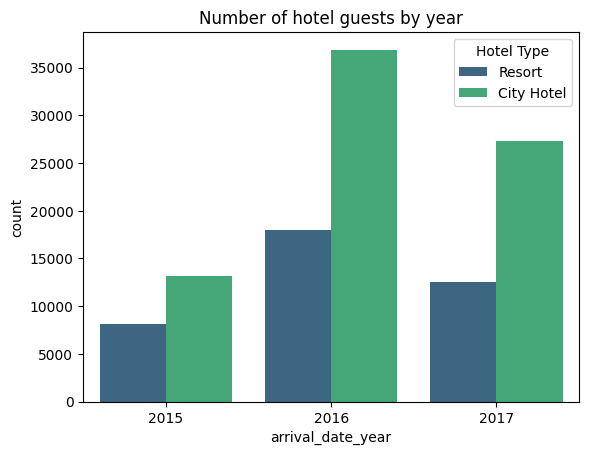

In [ ]:
sns.countplot(data=df.replace({'hotel': {1: 'Resort', 2: 'City Hotel'}}), x='arrival_date_year', hue='hotel', palette='viridis')
plt.title('Number of hotel guests by year')
plt.legend(title='Hotel Type', loc='upper right')
plt.show()


Text(0.5, 1.0, 'Hotel reservation status by year')

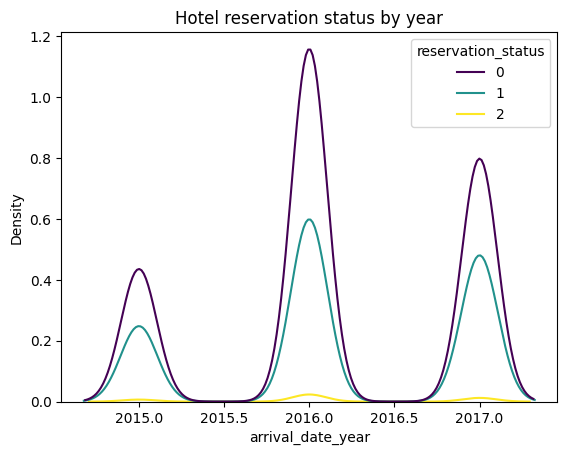

In [ ]:

sns.kdeplot(df,x='arrival_date_year',bw_method=.15,hue='reservation_status', palette='viridis')
plt.title('Hotel reservation status by year')

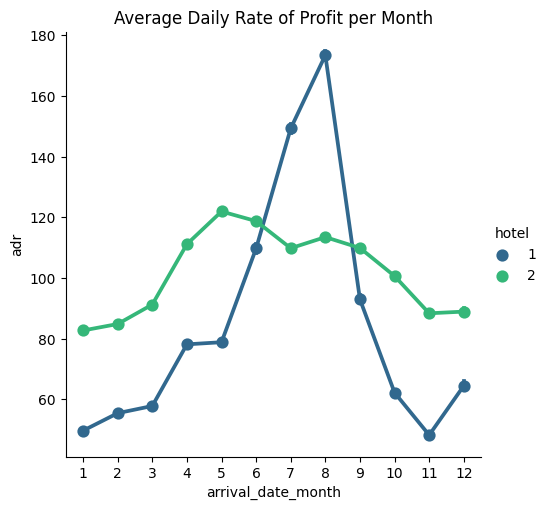

In [ ]:
sns.catplot(x="arrival_date_month", y="adr", hue = "hotel", data=df, kind="point", palette='viridis')
plt.title('Average Daily Rate of Profit per Month')

plt.show()

#### Domain knowledge binning on Country Feature. 


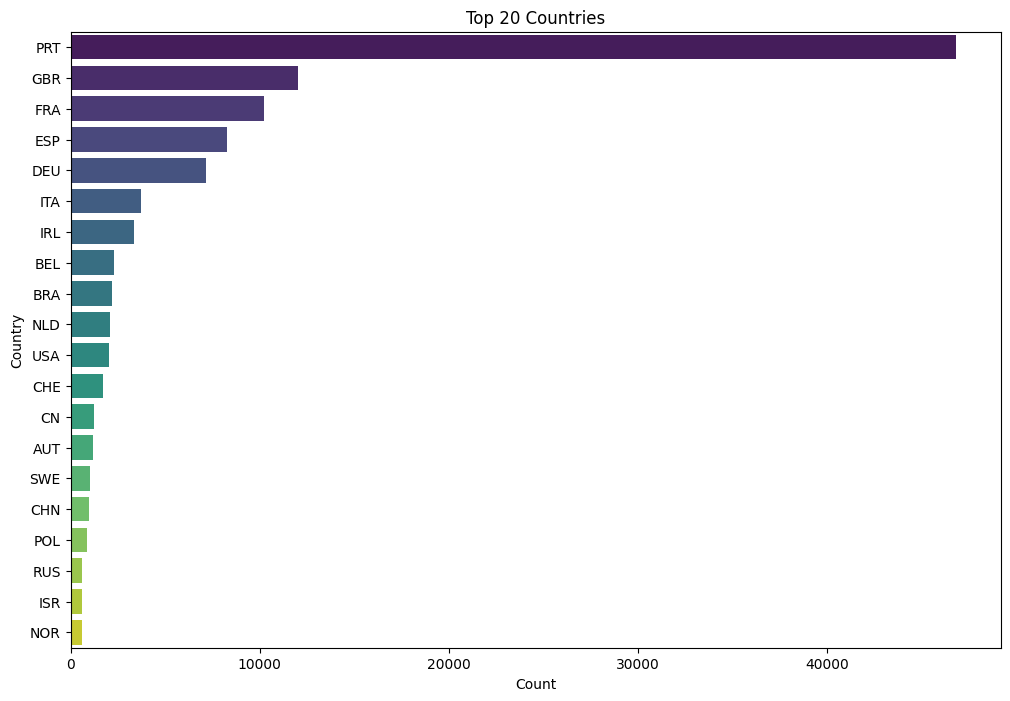

In [ ]:
country = pd.DataFrame(df['country'].value_counts())
top_20_countries = country.head(20)
top_20_countries = top_20_countries.reset_index()

top_20_countries.columns = ['Country', 'Count']
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Country', data=top_20_countries, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Country')
plt.title('Top 20 Countries')
plt.show()

In [ ]:
def categorize_country(country_code):
    if country_code == 'PRT':
        return 1  # Portugal
    elif country_code in ['DEU', 'FRA', 'ESP', 'ITA', 'GBR', 'ITA', 'IRL', 'BEL', 'NDL', 'CHE', 'CN', 'AUS', 'SWE', 'POL', 'NOR']:  # European countries excluding Portugal
        return 2  # Europe
    elif country_code == 'USA':
        return 3  # USA
    elif country_code == 'JPN':
        return 4  # Japan
    elif country_code == 'BRA':
        return 5  # Brazil
    elif country_code == 'CHN':
        return 6  # China
    else:
        return 7  # Rest


df['country'] = df['country'].apply(categorize_country)



In [ ]:
country_code_specif = ['Portugal', 'Europe', 'USA', 'Japan', 'Brazil', 'China', 'Rest']

In [ ]:
country_mapping = {1: 'Portugal', 2: 'Europe', 3: 'USA', 4: 'Japan', 5: 'Brazil', 6: 'China', 7: 'Rest'}

country_counts = pd.DataFrame(df['country'].value_counts())
print(country_counts)


         count
country       
2        52993
1        46836
7        10641
5         2203
3         2034
6          995
4          196


In [ ]:
country_counts = country_counts.reset_index()
country_counts['index'] = country_counts['index'].map(country_mapping)




KeyError: 'index'

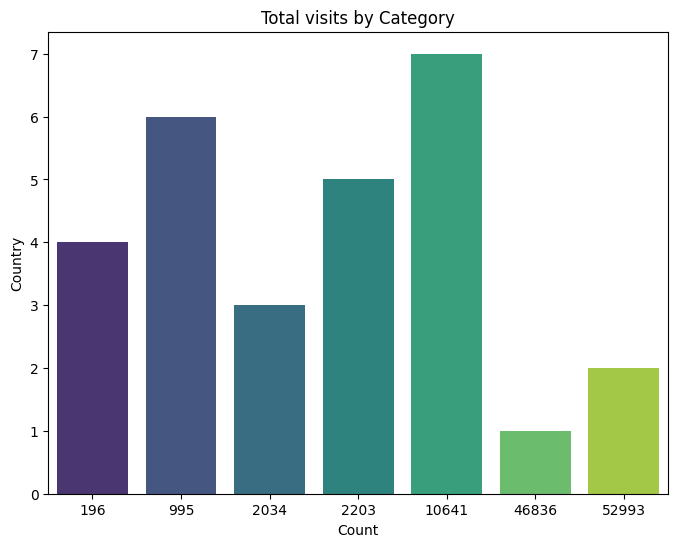

In [ ]:
country_counts.columns = ['Country', 'Count']

plt.figure(figsize=(8, 6))
sns.barplot(x='Count', y='Country', data=country_counts, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Country')
plt.title('Total visits by Category')
plt.show()


### Analysis on correlations 

In [ ]:
correlation_cancelled = df.corr()['is_canceled']
correlation_cancelled.abs().sort_values(ascending=False)[1:].round(2)*100

reservation_status                98.0
deposit_type                      48.0
lead_time                         29.0
market_segment                    24.0
total_of_special_requests         23.0
required_car_parking_spaces       19.0
distribution_channel              17.0
country                           14.0
booking_changes                   14.0
hotel                             13.0
customer_type                     13.0
previous_cancellations            11.0
days_in_waiting_list              10.0
is_repeated_guest                  9.0
adults                             6.0
previous_bookings_not_canceled     6.0
adr                                5.0
stays_in_week_nights               2.0
meal                               2.0
arrival_date_year                  2.0
families                           1.0
arrival_date_month                 1.0
arrival_date_week_number           1.0
stays_in_weekend_nights            0.0
arrival_date_day_of_month          0.0
Name: is_canceled, dtype:



Due to the incredible correlation between reservation_status and is_canceled, reservation status will be droped.


In [ ]:
df = df.drop('reservation_status', axis=1)

### Duplication 

In [ ]:
df.drop_duplicates()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,families
0,1,0,342,2015,7,27,1,0,0,2,...,0,0,3,0,0,0,0.00,0,0,0
1,1,0,737,2015,7,27,1,0,0,2,...,0,0,4,0,0,0,0.00,0,0,0
2,1,0,7,2015,7,27,1,0,1,1,...,0,0,0,0,0,0,75.00,0,0,0
3,1,0,13,2015,7,27,1,0,1,1,...,0,0,0,0,0,0,75.00,0,0,0
4,1,0,14,2015,7,27,1,0,2,2,...,0,0,0,0,0,0,98.00,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,2,0,23,2017,8,35,30,2,5,2,...,0,0,0,0,0,0,96.14,0,0,0
119386,2,0,102,2017,8,35,31,2,5,3,...,0,0,0,0,0,0,225.43,0,2,0
119387,2,0,34,2017,8,35,31,2,5,2,...,0,0,0,0,0,0,157.71,0,4,0
119388,2,0,109,2017,8,35,31,2,5,2,...,0,0,0,0,0,0,104.40,0,0,0


### Create models 

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:

def apply_models_pca_regression(X, y):

    #Apply PCA
    pca = PCA()
    X_pca = pca.fit_transform(X)

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Logistic Regression
    logistic_model = LogisticRegression(solver='lbfgs', max_iter=1000)
    logistic_model.fit(X_train_scaled, y_train)
    logistic_preds_train = logistic_model.predict(X_train_scaled)
    logistic_preds_test = logistic_model.predict(X_test_scaled)
    logistic_accuracy_train = accuracy_score(y_train, logistic_preds_train)
    logistic_accuracy_test = accuracy_score(y_test, logistic_preds_test)


    # SVN
    svm = LinearSVC()
    svm.fit(X_train_scaled, y_train)
    svm_preds_train = svm.predict(X_train_scaled)
    svm_preds_test = svm.predict(X_test_scaled)
    svm_accuracy_train = accuracy_score(y_train, svm_preds_train)
    svm_accuracy_test = accuracy_score(y_test, svm_preds_test)


    # Create a grid to display the results
    results = pd.DataFrame(
        {
            'Model': ['Logistic Regression', 'SVN '],
            'Accuracy/RMSE (Train)': [logistic_accuracy_train, svm_accuracy_train],
            'Accuracy/RMSE (Test)': [logistic_accuracy_test, svm_accuracy_test]
        }
    )
    print(results)

In [ ]:
y = df['is_canceled']
X = df.drop('is_canceled', axis=1)

In [ ]:
apply_models_pca_regression(X, y)
     

                 Model  Accuracy/RMSE (Train)  Accuracy/RMSE (Test)
0  Logistic Regression               0.792082              0.791429
1                 SVN                0.788236              0.787144


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)  
X = pca.fit_transform(X)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

svm = SVC()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'C': [0.1],
    'kernel': ['rbf'],
    'gamma': [0.1, 1]
}

grid_search = GridSearchCV(svm, param_grid)
grid_search.fit(X_train_scaled, y_train)

best_svm = grid_search.best_estimator_

best_svm.fit(X_train_scaled, y_train)

svm_preds_train = best_svm.predict(X_train_scaled)
svm_preds_test = best_svm.predict(X_test_scaled)

svm_accuracy_train = accuracy_score(y_train, svm_preds_train)
svm_accuracy_test = accuracy_score(y_test, svm_preds_test)

print('Accuracy (Train): %.2f' % (svm_accuracy_train))
print('Accuracy (Test): %.2f' % (svm_accuracy_test))
